In [1]:
import grafiti as gf
import cellcharter as cc
from utag import utag
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata
import squidpy as sq
import scanpy as sc
import scvi
import seaborn as sns
from scipy.stats import norm
import random
from sklearn.metrics import adjusted_rand_score, silhouette_score, davies_bouldin_score, mutual_info_score
import warnings
warnings.filterwarnings("ignore")

/home/pourmalm/ondconda/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/pourmalm/ondconda/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
 captum (see https://github.com/pytorch/captum).


# Scenario 3 synthetic

In [2]:
def generate_synthetic_dataset(
    num_cells=2000,
    cluster_probability=0.5,
    cluster_size=100,
    cluster_radius=0.01,
    marker_means_A=(0.3, 0.8), 
    marker_means_B=(0.8, 0.3),
    marker_SDs_A=(0.1, 0.1), 
    marker_SDs_B=(0.1, 0.1),
    dispersed_distance=0.05,
    num_markers=4):

    random.seed(25)
    np.random.seed(25)
    
    # Generate unique x and y coordinates for all cells in the range [0, 1)
    x = np.random.rand(num_cells)
    y = np.random.rand(num_cells)

    # Generate topology (clustered or dispersed) based on x and y coordinates
    topology = np.where(np.random.rand(num_cells) < cluster_probability, 'clustered', 'dispersed')

    # Adjust x and y coordinates for clustered cells
    clustered_indices = np.where(topology == 'clustered')[0]
    for i in range(0, len(clustered_indices), cluster_size):
        cluster_x = np.random.normal(loc=x[clustered_indices[i]], scale=cluster_radius,
                                      size=min(cluster_size, len(clustered_indices) - i))
        cluster_y = np.random.normal(loc=y[clustered_indices[i]], scale=cluster_radius,
                                      size=min(cluster_size, len(clustered_indices) - i))

        # Clip the generated coordinates to ensure they are within [0, 1)
        cluster_x = np.clip(cluster_x, 0, 1)
        cluster_y = np.clip(cluster_y, 0, 1)

        # Filter out indices where the generated coordinates are too close to existing clustered cells
        valid_indices = np.where(
            (np.abs(cluster_x - x[clustered_indices[i:i + cluster_size]]) > cluster_radius) |
            (np.abs(cluster_y - y[clustered_indices[i:i + cluster_size]]) > cluster_radius))[0]

        # Update only the valid indices with the new coordinates
        x[clustered_indices[i:i + cluster_size][valid_indices]] = cluster_x[valid_indices]
        y[clustered_indices[i:i + cluster_size][valid_indices]] = cluster_y[valid_indices]

    # Adjust x and y coordinates for dispersed cells based on clustered cells
    dispersed_indices = np.where(topology == 'dispersed')[0]
    for i in dispersed_indices:
        # Check if the dispersed cell is within a specified distance of any clustered cell
        while any(
                np.sqrt((x[i] - x[clustered_indices]) ** 2 + (y[i] - y[clustered_indices]) ** 2) < dispersed_distance):
            # If the dispersed cell is too close to a cluster, generate new coordinates
            x[i] = np.random.uniform(low=0, high=1)
            y[i] = np.random.uniform(low=0, high=1)

    # Assign cell types based on coordinates
    celltype_A_mask = (x < 0.5) & (y >= 0) & (y <= 1)
    celltype_B_mask = (x >= 0.5) & (y >= 0) & (y <= 1)

    # Generate marker values using bimodal distribution for each marker
    markers = []
    for i in range(num_markers):
        # Determine the upregulated and downregulated cell types
        upregulated_celltype = 'celltype_B' if i % 2 == 0 else 'celltype_A'
        downregulated_celltype = 'celltype_A' if i % 2 == 0 else 'celltype_B'
        
        # Generate values for the upregulated cell type
        upregulated_values = np.clip(np.random.normal(loc=marker_means_A[i % 2], scale=marker_SDs_A[i % 2], size=num_cells), 0, 1)
        
        # Generate values for the downregulated cell type
        downregulated_values = np.clip(np.random.normal(loc=marker_means_B[i % 2], scale=marker_SDs_B[i % 2], size=num_cells), 0, 1)
        
        # Combine values based on the cell type
        marker_values = np.where(celltype_A_mask, upregulated_values, downregulated_values)
        markers.append(marker_values)

    # Create a DataFrame to store the synthetic dataset
    data_dict = {'x': x, 
                 'y': y, 
                 'celltype': np.where(celltype_A_mask, 'celltype_A', 'celltype_B'), 
                 'topology': topology}
    for i in range(num_markers):
        data_dict[f'marker_{i+1}'] = markers[i]

    synthetic_data = pd.DataFrame(data_dict)

    return synthetic_data

In [3]:
synthetic_dataset = generate_synthetic_dataset(num_cells=2000,
                                               cluster_probability=0.5,
                                               cluster_size=50,
                                               cluster_radius=0.01,
                                               marker_means_A=(0.3, 0.8),
                                               marker_means_B=(0.8, 0.3),
                                               marker_SDs_A=(0.1, 0.1),
                                               marker_SDs_B=(0.1, 0.1),
                                               dispersed_distance=0.05,
                                               num_markers=4)

          x         y    celltype   topology  marker_1  marker_2  marker_3  \
0  0.870124  0.328111  celltype_B  dispersed  0.699432  0.219328  0.730925   
1  0.358537  0.186609  celltype_A  dispersed  0.366397  0.856379  0.191273   
2  0.278839  0.579275  celltype_A  clustered  0.459544  0.858277  0.243844   
3  0.185911  0.381066  celltype_A  dispersed  0.284932  0.861585  0.302339   
4  0.982127  0.656187  celltype_B  dispersed  0.706814  0.311741  0.726999   

   marker_4  
0  0.368835  
1  0.733455  
2  0.818594  
3  0.612915  
4  0.241830  


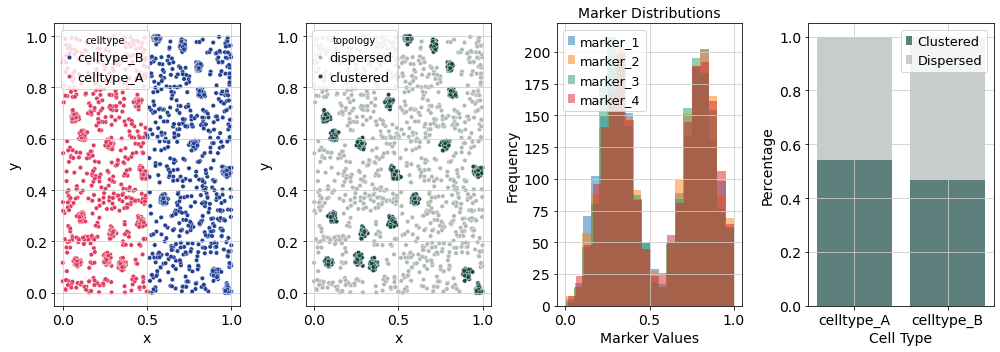

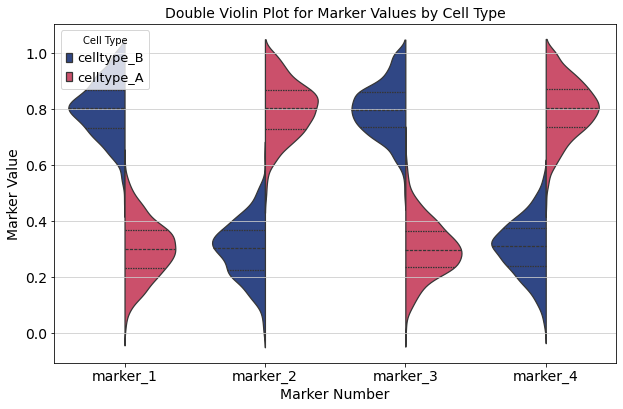

In [4]:
print(synthetic_dataset.head())
plt.figure(figsize=(14, 5))

# Plot color-coded by cell type
plt.subplot(1, 4, 1)
sns.scatterplot(x=synthetic_dataset['x'], y=synthetic_dataset['y'], hue=synthetic_dataset['celltype'], s=20, palette={'celltype_A':'#df3c5f', 'celltype_B':'#224193'})

# Plot color-coded by topology
plt.subplot(1, 4, 2)
sns.scatterplot(x=synthetic_dataset['x'], y=synthetic_dataset['y'], hue=synthetic_dataset['topology'], s=20, palette={'clustered':'#184A45FF', 'dispersed':'#B0B8B4FF'})

# Plot histograms for marker_1 and marker_2
plt.subplot(1, 4, 3)
plt.hist(synthetic_dataset['marker_1'], bins=20, alpha=0.5, label='marker_1')
plt.hist(synthetic_dataset['marker_2'], bins=20, alpha=0.5, label='marker_2')
plt.hist(synthetic_dataset['marker_3'], bins=20, alpha=0.5, label='marker_3')
plt.hist(synthetic_dataset['marker_4'], bins=20, alpha=0.5, label='marker_4')
plt.title('Marker Distributions')
plt.xlabel('Marker Values')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()

# Plot percentage of cells in each cell type that are clustered or dispersed
plt.subplot(1, 4, 4)
clustered_percentages = synthetic_dataset.groupby('celltype')['topology'].value_counts(normalize=True)[:, 'clustered']
dispersed_percentages = synthetic_dataset.groupby('celltype')['topology'].value_counts(normalize=True)[:, 'dispersed']
bar_positions = np.arange(len(clustered_percentages))
plt.bar(bar_positions, clustered_percentages, label='Clustered', color='#184A45FF', alpha=0.7)
plt.bar(bar_positions, dispersed_percentages, bottom=clustered_percentages, label='Dispersed', color='#B0B8B4FF', alpha=0.7)
plt.xlabel('Cell Type')
plt.ylabel('Percentage')
plt.xticks(bar_positions, clustered_percentages.index)
plt.legend()

# Plot marker intensities by cell type (double violin plot)
melted_data = pd.melt(synthetic_dataset, id_vars=['celltype'], value_vars=['marker_1', 'marker_2', 'marker_3', 'marker_4'])
plt.figure(figsize=(10, 6))
sns.violinplot(x='variable', y='value', hue='celltype', data=melted_data, split=True, inner='quart', palette={'celltype_A':'#df3c5f', 'celltype_B':'#224193'})
plt.title('Double Violin Plot for Marker Values by Cell Type')
plt.xlabel('Marker Number')
plt.ylabel('Marker Value')
plt.legend(title='Cell Type')
plt.show()

In [5]:
synthetic_dataset["fov"] = "FOV1"
synthetic_dataset["fov"] = synthetic_dataset["fov"].astype("category")
features = ["marker_1", "marker_2", "marker_3", "marker_4"]
obs_features = ["x", "y", "celltype", "topology", "fov"]
adata = anndata.AnnData(X = synthetic_dataset[features].to_numpy(), obs = synthetic_dataset[obs_features])
adata.var_names = synthetic_dataset[features].columns
adata.obsm['spatial'] = adata.obs[["x","y"]].to_numpy()
sq.gr.spatial_neighbors(adata,radius=10,coord_type='generic',delaunay=True,library_key="fov")
adata

AnnData object with n_obs × n_vars = 2000 × 4
    obs: 'x', 'y', 'celltype', 'topology', 'fov'
    uns: 'spatial_neighbors'
    obsm: 'spatial'
    obsp: 'spatial_connectivities', 'spatial_distances'

## Grafiti

In [6]:
gae = gf.ml.GAE(adata, layers=[10], lr=0.1, distance_threshold=0.08)

Generating PyTorch Geometric Dataset...
Setting up Model...
Ready to train!


Epoch 0 ** iteration 0 ** Loss: 8948.8046875
Epoch 20 ** iteration 20 ** Loss: 7691.390942382813
Epoch 40 ** iteration 40 ** Loss: 5586.523217773438
Epoch 60 ** iteration 60 ** Loss: 3905.4988403320312
Epoch 80 ** iteration 80 ** Loss: 2579.8882080078124
Epoch 100 ** iteration 100 ** Loss: 1626.2146301269531
Epoch 120 ** iteration 120 ** Loss: 1009.9790771484375
Epoch 140 ** iteration 140 ** Loss: 630.2289840698243
Epoch 160 ** iteration 160 ** Loss: 387.14879455566404
Epoch 180 ** iteration 180 ** Loss: 224.0442626953125
Epoch 200 ** iteration 200 ** Loss: 116.34562225341797
Epoch 220 ** iteration 220 ** Loss: 53.42452259063721
Epoch 240 ** iteration 240 ** Loss: 22.632285642623902
Epoch 260 ** iteration 260 ** Loss: 9.788767981529237
Epoch 280 ** iteration 280 ** Loss: 4.573493731021881
Epoch 300 ** iteration 300 ** Loss: 2.276241195201874
Epoch 320 ** iteration 320 ** Loss: 1.1952929109334947
Epoch 340 ** iteration 340 ** Loss: 0.6914528161287308
Epoch 360 ** iteration 360 ** Loss: 

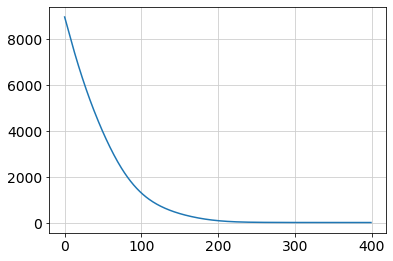

In [7]:
gae.train(400, update_interval=20)
gae.plot()

In [8]:
gae.load_embedding(adata,encoding_key="X_grafiti")
sc.pp.neighbors(adata,use_rep="X_grafiti")
sc.tl.umap(adata)

In [9]:
gf.tl.sap_clusters(adata, resolution=0.03, method="leiden", cluster_key="gm")

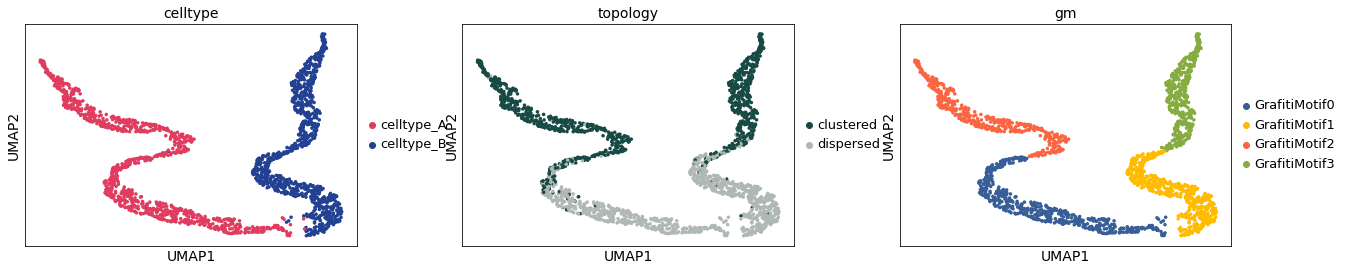

In [10]:
colors={'celltype_A':'#df3c5f','celltype_B':'#224193','clustered':'#184A45FF','dispersed':'#B0B8B4FF',
        'GrafitiMotif0':'#375e97', 'GrafitiMotif1':'#ffbb00', 'GrafitiMotif2':'#fb6542', 'GrafitiMotif3':'#86ac41'}
sc.pl.umap(adata,color=["celltype","topology","gm"], s=50, add_outline=False, wspace=0.2, 
           legend_loc='right margin',palette=colors)

<Axes: xlabel='x', ylabel='y'>

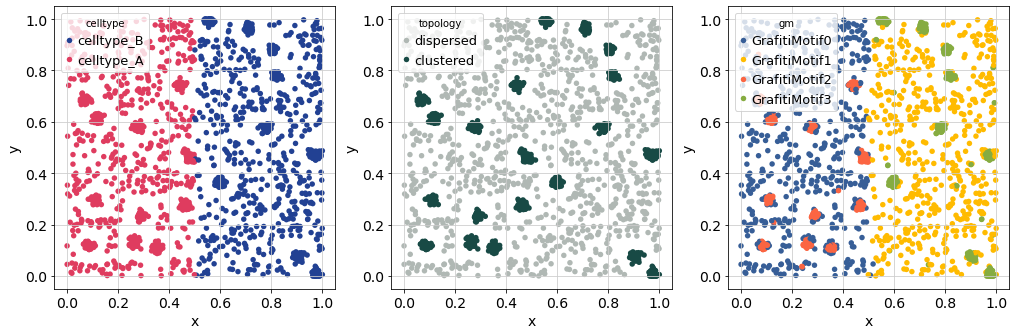

In [11]:
plt.figure(figsize=(17, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(x=synthetic_dataset['x'], y=synthetic_dataset['y'], hue=synthetic_dataset['celltype'], s=30, linewidth=0.001, palette={'celltype_A':'#df3c5f', 'celltype_B':'#224193'})
plt.subplot(1, 3, 2)
sns.scatterplot(x=synthetic_dataset['x'], y=synthetic_dataset['y'], hue=synthetic_dataset['topology'], s=30, linewidth=0.001, palette={'clustered':'#184A45FF', 'dispersed':'#B0B8B4FF'})
plt.subplot(1, 3, 3)
sns.scatterplot(x=adata.obs['x'], y=adata.obs['y'], hue=adata.obs['gm'], s=30, linewidth=0.001, palette={'GrafitiMotif0':'#375e97', 'GrafitiMotif1':'#ffbb00', 'GrafitiMotif2':'#fb6542', 'GrafitiMotif3':'#86ac41'})
# plt.savefig("scenario3_fovplot.pdf", transparent=None, dpi='figure', format=None,
#         metadata=None, bbox_inches=None, pad_inches=0.1,
#         facecolor='auto', edgecolor='auto', backend=None)

## CellCharter

In [12]:
scvi.settings.seed = 12345
scvi.model.SCVI.setup_anndata(
    adata,
    batch_key='fov'
)
model = scvi.model.SCVI(adata)

Global seed set to 12345


In [13]:
model.train(early_stopping=True, enable_progress_bar=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████████| 400/400 [01:26<00:00,  5.13it/s, v_num=1, train_loss_step=3.26, train_loss_epoch=3.28]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:26<00:00,  4.61it/s, v_num=1, train_loss_step=3.26, train_loss_epoch=3.28]


In [14]:
adata.obsm['X_scVI'] = model.get_latent_representation(adata).astype(np.float32)

In [15]:
gmm = cc.tl.Cluster(
    n_clusters=4, 
    random_state=12345,
)

In [17]:
gmm.fit(adata, use_rep='X_scVI')
adata.obs['cc'] = gmm.predict(adata, use_rep='X_scVI')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

<Axes: xlabel='x', ylabel='y'>

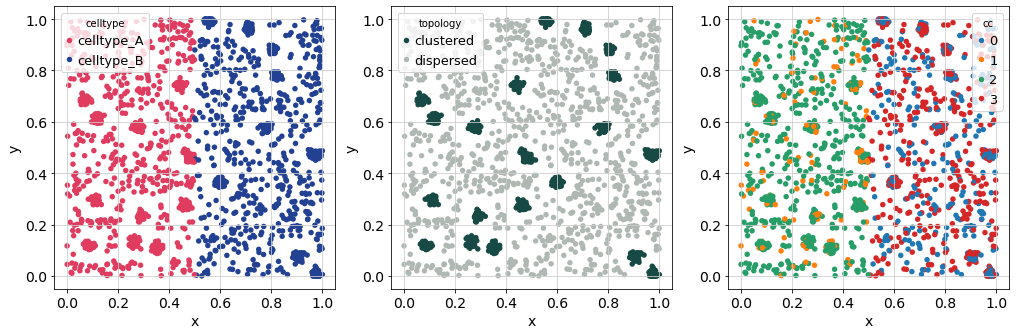

In [18]:
plt.figure(figsize=(17, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(x=adata.obs['x'], y=adata.obs['y'], hue=adata.obs['celltype'], s=30, linewidth=0.001, palette={'celltype_A':'#df3c5f', 'celltype_B':'#224193'})
plt.subplot(1, 3, 2)
sns.scatterplot(x=adata.obs['x'], y=adata.obs['y'], hue=adata.obs['topology'], s=30, linewidth=0.001, palette={'clustered':'#184A45FF', 'dispersed':'#B0B8B4FF'})
plt.subplot(1, 3, 3)
sns.scatterplot(x=adata.obs['x'], y=adata.obs['y'], hue=adata.obs['cc'], s=30, linewidth=0.001)
# plt.savefig("scenario3_fovplot.pdf", transparent=None, dpi='figure', format=None,
#         metadata=None, bbox_inches=None, pad_inches=0.1,
#         facecolor='auto', edgecolor='auto', backend=None)

## UTAG

In [20]:
utag_results = utag(
    adata,
    slide_key="fov",
    max_dist=15,
    normalization_mode='l1_norm',
    apply_clustering=True,
    clustering_method = 'leiden', 
    resolutions = [0.33]
)

Applying UTAG Algorithm...


  0%|          | 0/1 [00:00<?, ?it/s]

Overwriding provided number of PCA dimensions to match number of features: 3


  0%|          | 0/1 [00:00<?, ?it/s]

Applying Leiden Clustering at Resolution: 0.33...


100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


<Axes: xlabel='x', ylabel='y'>

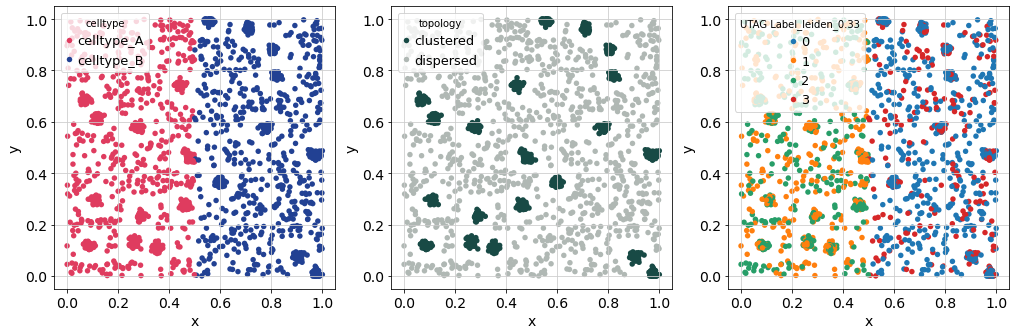

In [91]:
plt.figure(figsize=(17, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(x=utag_results.obs['x'], y=utag_results.obs['y'], hue=utag_results.obs['celltype'], s=30, linewidth=0.001, palette={'celltype_A':'#df3c5f', 'celltype_B':'#224193'})
plt.subplot(1, 3, 2)
sns.scatterplot(x=utag_results.obs['x'], y=utag_results.obs['y'], hue=utag_results.obs['topology'], s=30, linewidth=0.001, palette={'clustered':'#184A45FF', 'dispersed':'#B0B8B4FF'})
plt.subplot(1, 3, 3)
sns.scatterplot(x=utag_results.obs['x'], y=utag_results.obs['y'], hue=utag_results.obs['UTAG Label_leiden_0.33'], s=30, linewidth=0.001)
# plt.savefig("scenario3_fovplot.pdf", transparent=None, dpi='figure', format=None,
#         metadata=None, bbox_inches=None, pad_inches=0.1,
#         facecolor='auto', edgecolor='auto', backend=None)

## Final comparison

<Axes: xlabel='x', ylabel='y'>

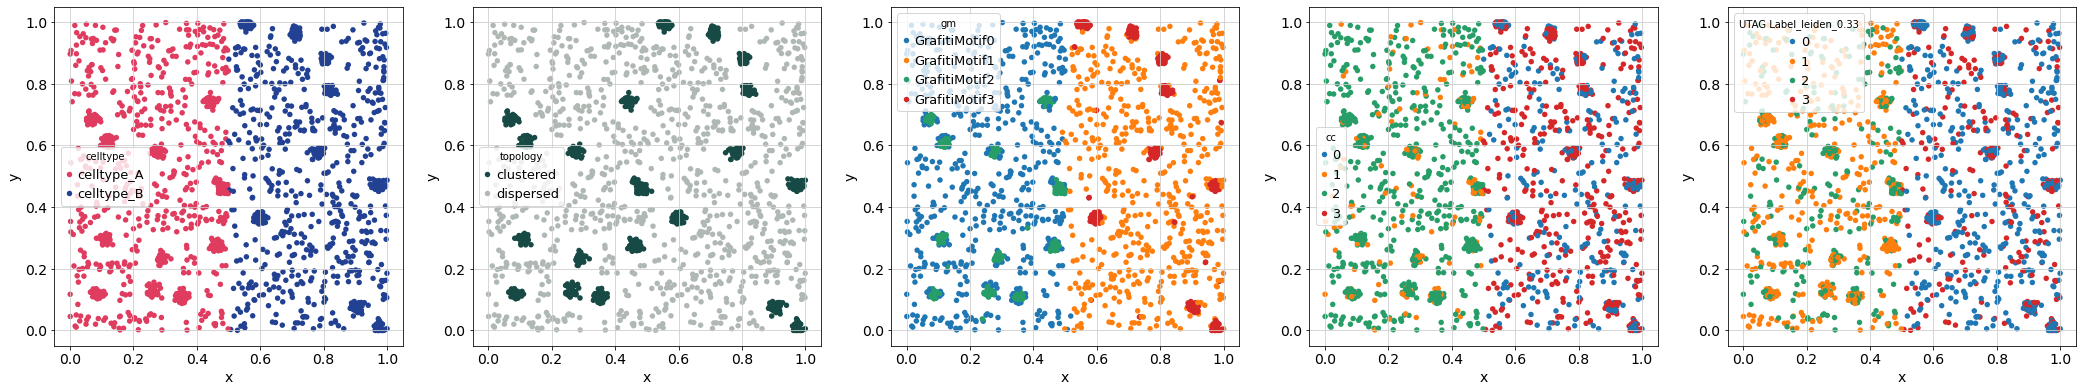

In [24]:
plt.figure(figsize=(36, 6))
plt.subplot(1, 5, 1)
sns.scatterplot(x=adata.obs['x'], y=adata.obs['y'], hue=adata.obs['celltype'], s=30, linewidth=0.001, palette={'celltype_A':'#df3c5f', 'celltype_B':'#224193'})
plt.subplot(1, 5, 2)
sns.scatterplot(x=adata.obs['x'], y=adata.obs['y'], hue=adata.obs['topology'], s=30, linewidth=0.001, palette={'clustered':'#184A45FF', 'dispersed':'#B0B8B4FF'})
plt.subplot(1, 5, 3)
sns.scatterplot(x=adata.obs['x'], y=adata.obs['y'], hue=adata.obs['gm'], s=30, linewidth=0.001)
plt.subplot(1, 5, 4)
sns.scatterplot(x=adata.obs['x'], y=adata.obs['y'], hue=adata.obs['cc'], s=30, linewidth=0.001)
plt.subplot(1, 5, 5)
sns.scatterplot(x=utag_results.obs['x'], y=utag_results.obs['y'], hue=utag_results.obs['UTAG Label_leiden_0.33'], s=30, linewidth=0.001)

In [50]:
# ari_us = adjusted_rand_score(adata.obs['celltype'],adata.obs['gm']) 
# ari_cc = adjusted_rand_score(adata.obs['celltype'],adata.obs['cc']) 
# ari_utag = adjusted_rand_score(utag_results.obs['celltype'],utag_results.obs['UTAG Label_leiden_0.33']) 
# print("ARI: celltype")
# print("grafiti:",ari_us)
# print("cellcharter:", ari_cc)
# print("utag:", ari_utag)

In [48]:
# ari_us = adjusted_rand_score(adata.obs['topology'],adata.obs['gm']) 
# ari_cc = adjusted_rand_score(adata.obs['topology'],adata.obs['cc']) 
# ari_utag = adjusted_rand_score(utag_results.obs['topology'],utag_results.obs['UTAG Label_leiden_0.33']) 
# print("ARI: topology")
# print("grafiti:",ari_us)
# print("cellcharter:", ari_cc)
# print("utag:", ari_utag)

In [51]:
dbs_us = davies_bouldin_score(adata.obsm['X_grafiti'], adata.obs["gm"])
dbs_cc = davies_bouldin_score(adata.obsm['X_scVI'], adata.obs["cc"]) 
dbs_ut = davies_bouldin_score(utag_results.obsm['X_pca'], utag_results.obs["UTAG Label_leiden_0.33"]) 
print("Davies–Bouldin index")
print("grafiti:",dbs_us)
print("cellcharter:",dbs_cc)
print("utag:",dbs_ut)

Davies–Bouldin index
grafiti: 0.867793657984882
cellcharter: 2.140027559576419
utag: 1.90726396683256


In [52]:
# mis_us = mutual_info_score(adata.obs['celltype'],adata.obs['gm']) 
# mis_cc = mutual_info_score(adata.obs['celltype'],adata.obs['cc']) 
# mis_utag = mutual_info_score(utag_results.obs['celltype'],utag_results.obs['UTAG Label_leiden_0.33']) 
# print("Mutual information score: celltype")
# print("grafiti:",mis_us)
# print("cellcharter:",mis_cc)
# print("utag:",mis_utag)

In [53]:
# mis_us = mutual_info_score(adata.obs['topology'],adata.obs['gm']) 
# mis_cc = mutual_info_score(adata.obs['topology'],adata.obs['cc']) 
# mis_utag = mutual_info_score(utag_results.obs['topology'],utag_results.obs['UTAG Label_leiden_0.33']) 
# print("Mutual information score: topology")
# print("grafiti:",mis_us)
# print("cellcharter:",mis_cc)
# print("utag:",mis_utag)